# MBI HW1 for CS students (academic year 2023/24, winter semester)

Add your code to this template.

# Module imports and function definitions

Below we import some useful modules and define several functions including those listed in the assignment. Do not modify this part.

In [1]:
# imports
import io
import os
import re
import gc
import sys
import random
import heapq
import queue
import logging
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger('mbi').setLevel(logging.DEBUG)
import itertools
import hashlib

import requests
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm.notebook import trange, tqdm

!pip install biopython
from Bio import SeqIO



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.7 MB/s eta 0:00:00


In [2]:
def _download_file(url):
  """Auxiliary function to download a file from an url and return it as a string."""
  logger = logging.getLogger('mbi')
  logger.debug(f"Downloading from '{url}'...")
  sys.stderr.flush()
  response = requests.get(url)
  if response.status_code != 200:
    raise Exception(f"Cannot access '{url}'! Status code {response.status_code}")
  return response.text


def read_fasta(url=None, filename=None):
  """Function reads sequences in a FASTA format and returns them as a list of strings consisting of letters A,C,G,T.
  It also returns a list of descriptions of these sequences. If filename is given and it exists,
  sequences are read from the file. Otherwise they are read from the URL and written to the file."""
  logger = logging.getLogger('mbi')

  # open file or url
  handle = None
  output_handle = None
  if filename is not None and os.path.isfile(filename) \
  and os.path.getsize(filename) > 0:
    handle = open(filename, 'r')
  elif url is not None:
    from urllib.request import urlopen
    handle = io.TextIOWrapper(urlopen(url), encoding='utf-8')
    if filename is not None:
      output_handle = open(filename, "w")

  real_genomes, real_genome_descriptions = [], []
  for gnum, genome in enumerate(SeqIO.parse(handle, "fasta")):
    if output_handle is not None:
      SeqIO.write(genome, output_handle, "fasta")
    sequence = str(genome.seq).replace('N', '')
    if not re.match(r'\A[ACGT]+\Z', sequence):
      raise ValueError(f"Bad genome characters in the input file")
    description = genome.description
    real_genomes.append(sequence)
    real_genome_descriptions.append(description)
    logger.debug(f"Parsed genome #{gnum}: {description[:70]}...")

  if output_handle is not None:
    output_handle.close()
  handle.close()

  return real_genomes, real_genome_descriptions


@njit
def c(x: str) -> str:
  """Returns complement of a single DNA base"""
  if x == 'A':
    return 'T'
  elif x == 'T':
    return 'A'
  elif x == 'C':
    return 'G'
  elif x == 'G':
    return 'C'
  else:
    return ""


@njit
def _reverse_complement(seq: str) -> str:
  """Returns reverse complement (opposite strand) of a DNA sequence"""
  return "".join([c(seq[i]) for i in range(len(seq)-1, -1, -1)])


@njit
def canonical(kmer: str) -> str:
  """Returns a canonical k-mer for the input k-mer. """
  comp_kmer = _reverse_complement(kmer)
  if kmer <= comp_kmer:
    return kmer
  else:
    return comp_kmer


@njit
def full_kmer_set(sequence: str, k: int) -> set[str]:
  """Function gets a string consisting of letters A,C,G,T representing a single genome and integer k and returns a Python set of all canonical k-mers of the input string."""
  result = set()
  for start in range(len(sequence) - k + 1):
    result.add(canonical(sequence[start:start+k]))
  return result


@njit
def mutate(sequence: str, p: float) -> str:
  """Function gets a string consisting of letters A,C,G,T representing a single genome and a mutation probability p (a real number between 0 and 1).
  For each base of the input string it will decide with probability p to mutate it or 1-p to leave it as it was.
  If the base is mutated, it is replaced by a randomly chosen base from the remaining three."""
  others = {x: "ACGT".replace(x, "") for x in "ACGT"}
  result = "".join([x if random.random() > p else others[x][random.randint(0, 2)] for x in sequence])
  return result

def shash(seq: str) -> int:
  """A hash function to be used for hashing k-mers in minimizers and MinHash"""
  hasher = hashlib.blake2b(salt=b'')
  hasher.update(seq.encode(encoding='utf-8'))
  d = hasher.digest()
  result = int.from_bytes(d[:5], byteorder='little')
  return result


# testing
print(f"{[x + '->' + c(x) for x in 'ACGT']}")
print(f"{_reverse_complement('AGTG')=}")
print(f"{_reverse_complement('CACT')=}")
print(f"{canonical('AGTG')=}")
print(f"{canonical('CACT')=}")
print(f"{list(full_kmer_set('CCAAGGTCCATC', k=3))=}")
print(f"{[mutate('AAAACCCCGGGGTTTT', p=0.25) for _ in range(5)]=}")
print(f"{shash('A' * 13)=}, {shash('ACTACTACTACTG')=} {shash('T'*12 + 'A')=}")


['A->T', 'C->G', 'G->C', 'T->A']
_reverse_complement('AGTG')='CACT'
_reverse_complement('CACT')='AGTG'
canonical('AGTG')='AGTG'
canonical('CACT')='AGTG'
list(full_kmer_set('CCAAGGTCCATC', k=3))=['CAA', 'CCA', 'ATC', 'ACC', 'AGG', 'AAG', 'GGA', 'GAC', 'ATG']
[mutate('AAAACCCCGGGGTTTT', p=0.25) for _ in range(5)]=['AACACCGCGGGGTTTT', 'AAAACACCGCGGTTTA', 'AAAATCCCGGGGTTTT', 'AAACCCCCGGGGTTTA', 'AACACCACAGGGTTTG']
shash('A' * 13)=281618300821, shash('ACTACTACTACTG')=687357743147 shash('T'*12 + 'A')=912656793854


## Downloading genomes

This part will download bacterial genomes and create mutated versions of genome 0 as described in the assignment. When you run this cell first time, the sequences will be downloaded from the internet and saved to `bacteria.fasta` file. Subsequently, this file will be read instead.

In [3]:
url = "http://compbio.fmph.uniba.sk/vyuka/mbi-data/du1/bacteria.fasta"
real_genomes, real_genome_descriptions = read_fasta(url=url, filename="bacteria.fasta")
if len(real_genomes) != 9:
  raise Exception("Some problem with reading sequences, perhaps delete bacteria.fasta file")
gc.collect()

DEBUG:mbi:Parsed genome #0: NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome...
DEBUG:mbi:Parsed genome #1: NZ_CP031922.1 Escherichia coli O26:H11 strain FWSEC0001 chromosome, co...
DEBUG:mbi:Parsed genome #2: NZ_CP083638.1 Escherichia fergusonii strain FDAARGOS_1499 chromosome, ...
DEBUG:mbi:Parsed genome #3: NC_007795.1 Staphylococcus aureus subsp. aureus NCTC 8325 chromosome, ...
DEBUG:mbi:Parsed genome #4: NC_016845.1 Klebsiella pneumoniae subsp. pneumoniae HS11286 chromosome...
DEBUG:mbi:Parsed genome #5: NC_002695.2 Escherichia coli O157:H7 str. Sakai DNA, complete genome...
DEBUG:mbi:Parsed genome #6: NZ_CP009756.1 Enterobacter cloacae strain GGT036 chromosome, complete ...
DEBUG:mbi:Parsed genome #7: NZ_AP019632.1 Enterobacter asburiae strain 1808-013 chromosome, comple...
DEBUG:mbi:Parsed genome #8: NZ_AP022508.1 Enterobacter bugandensis strain STN0717-56 chromosome, c...


28512

In [4]:
mutation_probabilities = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
random.seed(47)
mutated_genomes = [mutate(real_genomes[0], p) for p in mutation_probabilities]
gc.collect()

0

## File writing function
additional function used only to write lists into text files

In [5]:
def write_to_file(file_name: str, list_to_write: list) -> str:
  try:
    with open(file_name, 'w') as f:
      for item in range(len(list_to_write)-1):
        f.write(str(list_to_write[item]))
        f.write('\n')
      f.write(str(list_to_write[-1]))
    return "File succesfully created"
  except Exception as e:
    #print(e)
    return "Error while creating file"

## Task 1: Jaccard similarity

Implement function `jaccard` below and run it on the real genomes as specified in the assignment.

In [6]:
def jaccard(first_set: set[str], list_of_sets: list[set[str]]) -> list[float]:
  # standard definition: length of intercept divided by legth of union compared sets
  similarities = [len(first_set & compared_set)/len(first_set | compared_set)
                  for compared_set in list_of_sets]
  return similarities

In [25]:
gen_0_set_of_kmer_13 = full_kmer_set(real_genomes[0], 13)
all_get_sets_of_kmer_13 = [full_kmer_set(real_genome, 13) for real_genome in real_genomes]
jaccard_sims = jaccard(gen_0_set_of_kmer_13, all_get_sets_of_kmer_13)
print(write_to_file("jaccard.txt", jaccard_sims))
del gen_0_set_of_kmer_13
del all_get_sets_of_kmer_13

File succesfully created


## Task 2: Minimizers

Implement function `minimizer_set` below and run it on a portion of genome 0 as specified in the assignment.

In [7]:
def minimizer_set(sequence: str, k: int, w: int) -> set[str]:
  number_of_total_kmers = len(sequence) - k + 1
  final_kmer_set = set()
  curr_kmers = [("", float('inf'))]*w
  for i in range(number_of_total_kmers):
    kmer = canonical(sequence[i:i+k])
    kmer_shash = shash(kmer)
    if i < w-1:
      curr_kmers[i] = (kmer_shash, kmer)
    else:
      curr_kmers[i%w] = (kmer_shash, kmer)
      min_kmer = min(curr_kmers, key=lambda x: x[0])
      final_kmer_set.add(min_kmer[1])
  return final_kmer_set

In [33]:
min_kmers = minimizer_set(real_genomes[0][:1000], 9, 5)
print(write_to_file("minimizers.txt", sorted(list(min_kmers))))
del min_kmers

File succesfully created


## Task 3: MinHash

Implement function `minhash_set` below and run it on a portion of genome 0 as specified in the assignment.

In [8]:
def minhash_set(sequence : str, k : int, m : int)-> set[str]:
  # number of bases in genome (negligible memory used)
  genome_length = len(sequence)
  # heap queue of kmers (we will maintain it length to be at most m kmers with one numerical value so ~O(m*(k+1))~O(m*k))
  heap_of_kmers = []
  # set where we maintain final kmers (we make sure there are always at most m kmers so memory used ~O(m*k))
  # (i decided to use it because it does not increase space complexity I can make sure that my heap will not contains one kmer multiple times)
  set_of_kmers = set()
  # number saying current length of heap (negligible memory used)
  length_of_heap = 0
  for start in range(genome_length - k + 1):
    kmer = canonical(sequence[start:start+k])
    kmer_shash = shash(kmer)
    if length_of_heap < m and kmer not in set_of_kmers:
      heapq.heappush(heap_of_kmers, (-kmer_shash, kmer))
      set_of_kmers.add(kmer)
      length_of_heap += 1
    else:
      max_shash = -heap_of_kmers[0][0]
      if kmer_shash < max_shash and kmer not in set_of_kmers:
        kmer_to_remove = heapq.heappop(heap_of_kmers)[1]
        heapq.heappush(heap_of_kmers, (-kmer_shash, kmer))
        set_of_kmers.discard(kmer_to_remove)
        set_of_kmers.add(kmer)
  # in total we used O(m*k) space for heap, O(m*k) for set and just O(1) or O(k) for others variabels
  # in total our space complexity is O(m*k)
  if length_of_heap == m:
    return set([heapq.heappop(heap_of_kmers)[1] for i in range(m)])
  else:
    raise("Less then m kmers")

In [ ]:
min_hash_kmers = minhash_set(real_genomes[0][:1000], 9, 30)
print(write_to_file("minhash.txt", sorted(list(min_hash_kmers))))
del min_hash_kmers

File succesfully created


Implement function `minhash_jaccard` below and run it on all real genomes as specified in the assignment.

In [9]:
def minhash_jaccard(first_set: set[str], list_of_sets: list[set[str]]) -> list[float]:
  length_of_first = len(first_set)
  similarities = []
  for i, compared_set in enumerate(list_of_sets):
    set_length = len(compared_set)
    if set_length != length_of_first:
      raise("Incorect length of set on index {i}".format(i))
    similarities.append(len(first_set & compared_set)/length_of_first)
  return similarities

In [ ]:
gen_0_set_of_kmer_13_minhash = minhash_set(real_genomes[0], 13, 100)
all_gen_sets_of_kmer_13_minhash = [minhash_set(genome, 13, 100) for genome in real_genomes]
minhash_jaccard_sims = minhash_jaccard(gen_0_set_of_kmer_13_minhash, all_gen_sets_of_kmer_13_minhash)
print(write_to_file("minhash_jaccard.txt", minhash_jaccard_sims))
del gen_0_set_of_kmer_13_minhash
del all_gen_sets_of_kmer_13_minhash
del minhash_jaccard_sims

Error while creating file


## Task 4: Accuracy of *k*-mer Jaccard index

Here compute quantities required in task 4.

In [15]:
# 1
# kmer at fixed position has probability (1-p)^k to not be changed during
# mutation because each position has probability 1-p to not be mutated
# and because they are independent probability of all of them to not be mutated
# is product of these probabilities, we have k positions so final value would be to k-th power
non_mutated_prob = lambda p, k: (1-p)**k
ks = [9, 13, 17]
non_mutated_kmer_prob = dict()
for k in ks:
  for p in mutation_probabilities:
    non_mutated_kmer_prob[k] = non_mutated_kmer_prob.get(k, [])+[non_mutated_prob(p, k)]

In [12]:
non_mutated_kmer_prob

{9: [0.9135172474836408,
  0.6302494097246091,
  0.3874204890000001,
  0.13421772800000006,
  0.04035360699999998,
  0.010077695999999997],
 13: [0.8775210229989678,
  0.5133420832795048,
  0.2541865828329001,
  0.054975581388800036,
  0.009688901040699992,
  0.0013060694015999993],
 17: [0.8429431933839268,
  0.4181203352191771,
  0.16677181699666577,
  0.022517998136852502,
  0.0023263051398720674,
  0.00016926659444735988]}

In [16]:
# 2
jaccard_sims_mutated = dict()
for k in ks:
  jaccard_sims_mutated[k] = jaccard(full_kmer_set(real_genomes[0], k), [full_kmer_set(genome, k) for genome in mutated_genomes])

In [27]:
jaccard_sims_mutated
for k in ks:
  print(k, end=" ")
  for j in jaccard_sims_mutated[k]:
    print("&", round(j, 3), end=" ")
  print("\\\\ \hline")

9 & 0.994 & 0.991 & 0.99 & 0.99 & 0.99 & 0.99 \\ \hline
13 & 0.804 & 0.414 & 0.233 & 0.119 & 0.087 & 0.075 \\ \hline
17 & 0.728 & 0.264 & 0.091 & 0.012 & 0.002 & 0.0 \\ \hline


In [ ]:
# number of different 9-mers in real genome 0
num_of_9mer = len(full_kmer_set(real_genomes[0], 9))
print(num_of_9mer)
# teoretical maximal number of 9-mers (on each of 9 position can be one of 4 bases
# but for each 9-mer exist it reverse complement and only smaller gets into set so divided by 2)
print(4**9/2)
print(num_of_9mer/(4**9/2))

129821
131072.0
0.9904556274414062


Text(0, 0.5, 'Jaccard similarity')

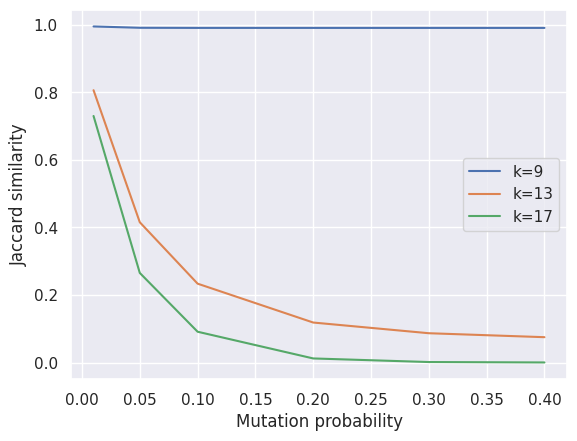

In [ ]:
# 3
for k in ks:
  plt.plot(mutation_probabilities, jaccard_sims_mutated[k], label="k={}".format(k))

plt.legend()
plt.xlabel("Mutation probability")
plt.ylabel("Jaccard similarity")

## Task 5: Jaccard index on real genomes

Here compute quantities required in task 5.

In [ ]:
# already done in task 1
print("Similarity to {}".format(real_genome_descriptions[0]))
for i in range(9):
  print("{:90}: {:1.4}".format(real_genome_descriptions[i], jaccard_sims[i]))

Similarity to NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome
NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome                    : 1.0
NZ_CP031922.1 Escherichia coli O26:H11 strain FWSEC0001 chromosome, complete genome       : 0.6436
NZ_CP083638.1 Escherichia fergusonii strain FDAARGOS_1499 chromosome, complete genome     : 0.2873
NC_007795.1 Staphylococcus aureus subsp. aureus NCTC 8325 chromosome, complete genome     : 0.06254
NC_016845.1 Klebsiella pneumoniae subsp. pneumoniae HS11286 chromosome, complete genome   : 0.1543
NC_002695.2 Escherichia coli O157:H7 str. Sakai DNA, complete genome                      : 0.5887
NZ_CP009756.1 Enterobacter cloacae strain GGT036 chromosome, complete genome              : 0.1582
NZ_AP019632.1 Enterobacter asburiae strain 1808-013 chromosome, complete genome           : 0.1546
NZ_AP022508.1 Enterobacter bugandensis strain STN0717-56 chromosome, complete genome      : 0.1558


## Task 6: Accuracy of minimizers and minhash

Here compute quantities required in task 5. You can combine tasks 6 and 7 here to run long computations only once.

In [10]:
k = 13
ws = [2, 5, 10]
ms = [10, 100, 1000]

minimizer_jaccard_sims = dict()
for w in ws:
  gene_0 = minimizer_set(real_genomes[0], k, w)
  all_genes = [minimizer_set(genome, k, w) for genome in mutated_genomes]
  minimizer_jaccard_sims[w] = jaccard(gene_0, all_genes)

minhash_jaccard_sims = dict()
for m in ms:
  gene_0 = minhash_set(real_genomes[0], k, m)
  all_genes = [minhash_set(genome, k, m) for genome in mutated_genomes]
  minhash_jaccard_sims[m] = minhash_jaccard(gene_0, all_genes)


In [28]:
minimizer_jaccard_sims
for w in ws:
  print(w, end=" ")
  for j in minimizer_jaccard_sims[w]:
    print("&", round(j, 4), end=" ")
  print("\\\\ \hline")

2 & 0.7972 & 0.3987 & 0.2162 & 0.1033 & 0.0737 & 0.0633 \\ \hline
5 & 0.7862 & 0.3774 & 0.1968 & 0.0897 & 0.0631 & 0.0539 \\ \hline
10 & 0.773 & 0.3563 & 0.1826 & 0.083 & 0.0585 & 0.0505 \\ \hline


In [29]:
minhash_jaccard_sims
for m in ms:
  print(m, end=" ")
  for j in minhash_jaccard_sims[m]:
    print("&", round(j, 4), end=" ")
  print("\\\\ \hline")

10 & 0.8 & 0.5 & 0.4 & 0.2 & 0.1 & 0.1 \\ \hline
100 & 0.88 & 0.6 & 0.4 & 0.25 & 0.18 & 0.17 \\ \hline
1000 & 0.895 & 0.595 & 0.377 & 0.212 & 0.148 & 0.139 \\ \hline


In [33]:
for w in ws:
  print(w, end=" ")
  for i, j in enumerate(minimizer_jaccard_sims[w]):
    print("&", round(jaccard_sims_mutated[13][i]-j, 4), end=" ")
  print("\\\\ \hline")

2 & 0.0067 & 0.0157 & 0.0171 & 0.0153 & 0.0132 & 0.0119 \\ \hline
5 & 0.0178 & 0.0371 & 0.0365 & 0.029 & 0.0238 & 0.0213 \\ \hline
10 & 0.031 & 0.0582 & 0.0507 & 0.0357 & 0.0284 & 0.0247 \\ \hline


In [36]:
for m in ms:
  print(m, end=" ")
  for i, j in enumerate(minhash_jaccard_sims[m]):
    print("&", round(jaccard_sims_mutated[13][i]-j, 4), end=" ")
  print("\\\\ \hline")

10 & 0.004 & -0.0855 & -0.1667 & -0.0814 & -0.0131 & -0.0248 \\ \hline
100 & -0.076 & -0.1855 & -0.1667 & -0.1314 & -0.0931 & -0.0948 \\ \hline
1000 & -0.091 & -0.1805 & -0.1437 & -0.0934 & -0.0611 & -0.0638 \\ \hline


Text(0, 0.5, 'Absolute difference to Jaccard similarity')

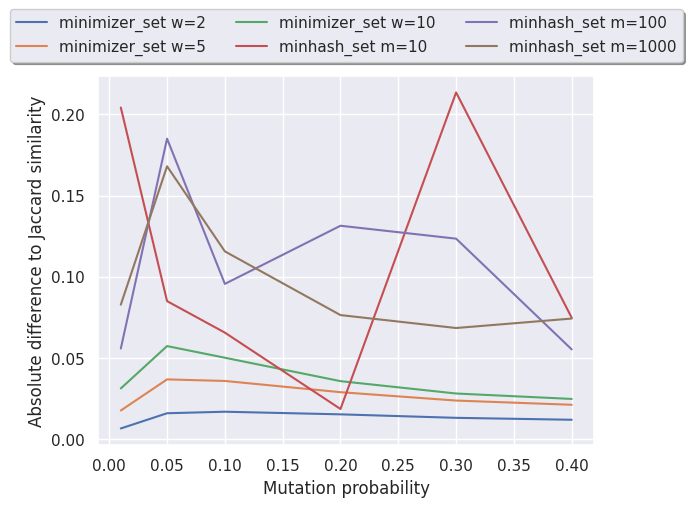

In [26]:
for w in ws:
  plt.plot(mutation_probabilities, np.absolute(
      np.array(minimizer_jaccard_sims[w])-
      np.array(jaccard_sims_mutated[13])), label="minimizer_set w={}".format(w))

for m in ms:
  plt.plot(mutation_probabilities, np.absolute(
      np.array(minhash_jaccard_sims[m])-
      np.array(jaccard_sims_mutated[13])), label="minhash_set m={}".format(m))

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=3, fancybox=True, shadow=True)
plt.xlabel("Mutation probability")
plt.ylabel("Absolute difference to Jaccard similarity")

## Task 7: Running time and memory

In [11]:
import time
k = 13
ws = [2, 5, 10]
ms = [10, 100, 1000]


In [13]:
print("Full k-mers set:")
start = time.perf_counter()
full = full_kmer_set(real_genomes[0], k)
stop = round(time.perf_counter() - start, 4)
print("space: {:7} time: {:.4}".format(len(full), stop))

print("Minimizer set:")
for w in ws:
  start = time.perf_counter()
  mini = minimizer_set(real_genomes[0], k, w)
  stop = round(time.perf_counter() - start, 4)
  print("w: {:4} space: {:7} time: {:.4}".format(w, len(mini), stop))

print("MinHash set:")
for m in ms:
  start = time.perf_counter()
  minH = minhash_set(real_genomes[0], k, m)
  stop = round(time.perf_counter() - start, 4)
  print("m: {:4} space: {:7} time: {:.4}".format(m, len(minH), stop))


Full k-mers set:
space: 3852750 time: 19.51
Minimizer set:
w:    2 space: 2629171 time: 45.01
w:    5 space: 1341096 time: 45.21
w:   10 space:  736529 time: 48.99
MinHash set:
m:   10 space:      10 time: 39.08
m:  100 space:     100 time: 38.82
m: 1000 space:    1000 time: 38.54
